# Notebook for backtesting the Machine Learning models

### In this notebook we will be using the saved joblib files, and using them to generate Buy / Dont buy signals for the data fetched from CCXT

The test data will be for the past 720 datapoints for each of 'BTC/AUD', 'ETH/AUD', 'XRP/AUD', 'LTC/AUD', 'ADA/AUD', 'XLM/AUD' and 'BCH/AUD'

In [68]:
# Import libraries and dependencies
import ccxt
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import talib as ta
import yfinance as yf 

from Utility_Functions import Functions

# Control parameters for the backtest

In [69]:
# One of '2021-09-01_ada_boost_Feat_sel.joblib' '2021-09-01_forest_Feat_sel.joblib' '2021-09-01_dec_tree_Feat_sel.joblib' '2021-09-01_logreg_Feat_sel.joblib'
model_for_testing = '2021-09-01_ada_boost_Feat_sel.joblib'                 # 

curr_list = ['BTC/AUD', 'ETH/AUD', 'XRP/AUD', 'LTC/AUD', 'ADA/AUD', 'XLM/AUD', 'BCH/AUD']

# indicators_list = ['BBands_high', 'BBands_low', 'RSI_ratio', 'CCI','ADX', 'ADX_dirn', 'SMA_vol_agg', 'MACD_ratio']    # for models before 30 Aug
# indicators_list = ['CCI', 'MACD_ratio', 'ADX', 'ADX_dirn','SMA_vol_agg']                                                  # for models after 30 Aug
all_inds = ['SMA_agg', 'RSI_ratio', 'CCI', 'MACD_ratio', 'ADX', 'ADX_dirn', 'ATR_ratio', 'BBands_high', 'BBands_low', 'SMA_vol_agg', 'Returns']


# Redownload the data just to check the time taken for each activity

In [70]:
# Load environment variables
load_dotenv()

# Import environment variables
kraken_public_key = os.getenv("KRAKEN_PUBLIC_KEY")
kraken_secret_key = os.getenv("KRAKEN_SECRET_KEY")

# Verify that environment variables were loaded
print(f"Kraken key data type: {type(kraken_public_key)}")
print(f"Kraken secren data type: {type(kraken_secret_key)}")

Kraken key data type: <class 'str'>
Kraken secren data type: <class 'str'>


### Set Public and private keys and initialise the CCXT Exchange object

In [71]:
# Set the public and private keys for the API
exchange = ccxt.kraken({
    'apiKey': kraken_public_key,
    'secret': kraken_secret_key,
})

if not exchange.has['fetchOHLCV']:
    print('Cant load history data with this exchange. Try with a different exchange')

### Fetching the price data

In [75]:
currs_list = curr_list     #

dict_ohlcv = {}

for curr in currs_list:
    
    # Call data fetch
    ohlcv = exchange.fetchOHLCV(curr, '1h')

    # Store the values in a dataframe
    df_ohlcv = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume']).set_index('Date')
    df_ohlcv.index = pd.to_datetime(df_ohlcv.index, unit='ms')

    df_ohlcv.dropna(inplace=True)

    # Store the symbol name and history data in a dict 
    dict_ohlcv[curr] = df_ohlcv 

    start_date = df_ohlcv.index[0].date().isoformat()
    end_date = df_ohlcv.index[-1].date().isoformat()
    num_records = (len(df_ohlcv))
    start_price = df_ohlcv.iloc[0]['Close']
    end_price = df_ohlcv.iloc[-1]['Close']

    print(f'Data summary for {curr}')
    print(f'    Start Date: {start_date}; End Date: {end_date}; NUmber of records: {num_records}')
    print(f'    Start Price: {start_price}; End Price: {end_price}')    
    print(f'Data for {curr} fetched and appended into the dictionary\n')

Data summary for BTC/AUD
    Start Date: 2021-08-03; End Date: 2021-09-02; NUmber of records: 720
    Start Price: 52427.4; End Price: 67526.2
Data for BTC/AUD fetched and appended into the dictionary

Data summary for ETH/AUD
    Start Date: 2021-08-03; End Date: 2021-09-02; NUmber of records: 720
    Start Price: 3407.54; End Price: 5068.09
Data for ETH/AUD fetched and appended into the dictionary

Data summary for XRP/AUD
    Start Date: 2021-08-03; End Date: 2021-09-02; NUmber of records: 720
    Start Price: 0.968; End Price: 1.71177
Data for XRP/AUD fetched and appended into the dictionary

Data summary for LTC/AUD
    Start Date: 2021-08-03; End Date: 2021-09-02; NUmber of records: 720
    Start Price: 184.78; End Price: 249.75
Data for LTC/AUD fetched and appended into the dictionary

Data summary for ADA/AUD
    Start Date: 2021-08-03; End Date: 2021-09-02; NUmber of records: 720
    Start Price: 1.76786; End Price: 4.12958
Data for ADA/AUD fetched and appended into the dictio

### Computing and adding Technical Indicators to the price data

In [73]:
fast_window = 5
slow_window = 15

df_all_data = pd.DataFrame() 
for curr, data in dict_ohlcv.items():

    df = Functions.add_tech_indicators(data, fast_window, slow_window)
    
    df['Currency'] = curr 
    df['Returns'] = df['Close'].pct_change()

    df.dropna(inplace=True)    
    df_all_data = df_all_data.append(df)

df_all_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_agg', 'RSI_ratio', 'CCI',
       'MACD_ratio', 'ADX', 'ADX_dirn', 'ATR_ratio', 'BBands_high',
       'BBands_low', 'SMA_vol_agg', 'Currency', 'Returns'],
      dtype='object')

# Extra backtesting - For earlier range, yfinance data can be downloaded and saved in a CSV

The data has been downloaded, indicators applied and saved to Resources/Backtesting_July.csv

In [54]:
df_all_data = pd.read_csv('Resources/Backtesting_July.csv', index_col=0, infer_datetime_format=True)
df_all_data.index.set_names('Date', inplace=True)
df_all_data.index = pd.to_datetime(df_all_data.index, utc=True)
df_all_data.index = df_all_data.index.tz_localize(tz=None)

curr_list = df_all_data.Currency.unique().tolist()
df_all_data.shape
df_all_data.index.dtype

dtype('<M8[ns]')

# Add the target values to compare the strategy predictions

In [55]:
df_all_data['Target_returns'] = df_all_data.Returns.shift(-1)
df_all_data.dropna(inplace=True)
df_all_data['Buy_or_sell'] = df_all_data.Target_returns.apply(lambda x: 1 if x > 0 else 0)
df_all_data.shape

(20382, 20)

# Backtesting this data

### Fetch the saved joblib file

In [56]:
from sklearn.pipeline import make_pipeline, Pipeline
from joblib import dump, load
from pathlib import Path

In [57]:
filename = 'Joblibs/' + model_for_testing
pipeline = load(filename)
print(f'Model {filename} loaded')

Model Joblibs/2021-09-01_ada_boost_Feat_sel.joblib loaded


### Start of predictions

In [58]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


Classification report for BTC/AUD
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      1432
           1       0.53      0.54      0.54      1481

    accuracy                           0.53      2913
   macro avg       0.52      0.52      0.52      2913
weighted avg       0.53      0.53      0.53      2913


Classification report for ETH/AUD
              precision    recall  f1-score   support

           0       0.53      0.52      0.52      1413
           1       0.55      0.56      0.56      1488

    accuracy                           0.54      2901
   macro avg       0.54      0.54      0.54      2901
weighted avg       0.54      0.54      0.54      2901


Classification report for XRP/AUD
              precision    recall  f1-score   support

           0       0.53      0.50      0.52      1420
           1       0.55      0.58      0.57      1505

    accuracy                           0.54      2925
   macro avg       0.54

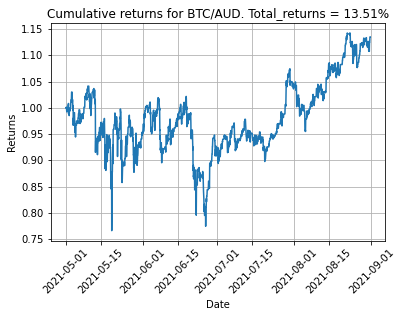

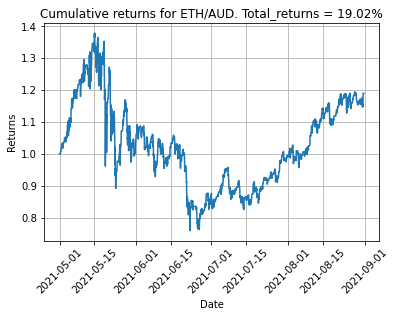

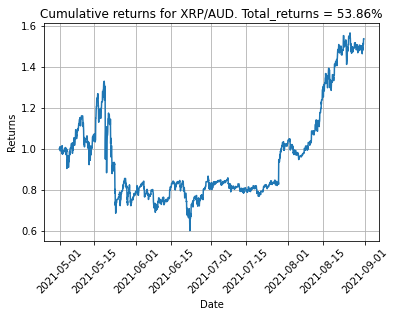

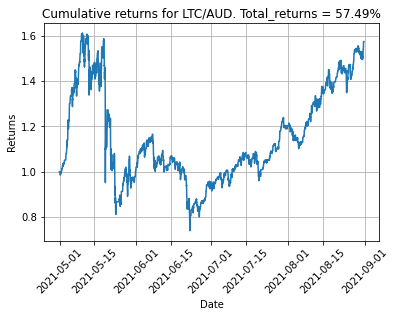

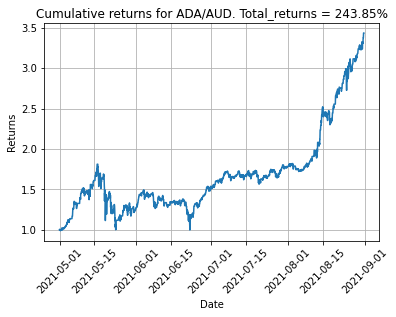

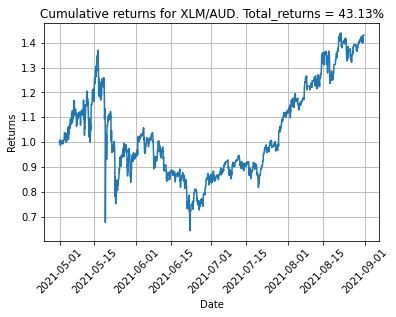

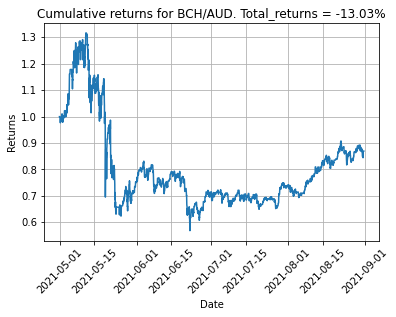

In [59]:
df_cml_rets = pd.DataFrame()
df_hourly_rets = pd.DataFrame()

for curr_tested in curr_list:

    df_testing_subset = df_all_data.loc[ df_all_data.Currency == curr_tested].copy()
    df_testing_subset.sort_index(inplace=True)

    X_test = df_testing_subset.loc[: , all_inds].reset_index(drop=True)   
    y_test = df_testing_subset.loc[:, ['Target_returns', 'Buy_or_sell']].copy()

    # Run the predictions
    df_pred = y_test
    df_pred['Pred_buy_or_sell'] = pipeline.predict(X_test)

    # print(df_pred)

    print(f'\nClassification report for {curr_tested}')
    print(classification_report(y_test.Buy_or_sell, df_pred.Pred_buy_or_sell))

    hourly_returns = df_pred['Target_returns'] * df_pred['Pred_buy_or_sell']
    cum_rets = (1 + hourly_returns).cumprod()
    total_returns = round((cum_rets[-1] - cum_rets[0]) * 100, 2)

    col_name = 'hourly_rets_'  + (curr_tested.replace('/', '-'))
    df_hourly_rets[col_name] = hourly_returns

    col_name = 'cum_rets_' + (curr_tested.replace('/', '-'))
    df_cml_rets[col_name] = cum_rets

    title = 'Cumulative returns for ' + curr_tested + '. Total_returns = ' + str(total_returns) + '%'
    png_file = 'Backtest_results/Results_' + curr_tested.replace('/','-') + '.png'

    fig, ax = plt.subplots()
    ax.plot(cum_rets)

    ax.set(xlabel='Date', ylabel='Returns',
        title= title)
    ax.grid()

    plt.xticks(rotation=45)

    fig.savefig(png_file)


# Getting the combined portfolio Returns and calculating evaluation metrics

<AxesSubplot:xlabel='Date'>

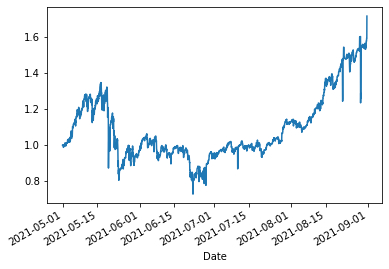

In [60]:
df_portfolio_returns = pd.DataFrame()


df_portfolio_returns['cum_rets_agg'] = df_cml_rets.mean(axis=1)
df_portfolio_returns['hourly_rets_agg'] = df_hourly_rets.mean(axis=1)

# print(df_portfolio_returns.head())
df_portfolio_returns.cum_rets_agg.plot()

In [61]:
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

,Backtest
Annual Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [62]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'] = df_portfolio_returns['cum_rets_agg'][-1]
portfolio_evaluation_df

,Backtest
Annual Return,NaN
Cumulative Returns,1.718098
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [63]:
# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'] = (
    df_portfolio_returns['hourly_rets_agg'].mean() * 24 * 365
)
portfolio_evaluation_df

,Backtest
Annual Return,1.873774
Cumulative Returns,1.718098
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [64]:
# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'] = (
    df_portfolio_returns['hourly_rets_agg'].std() * np.sqrt(24 * 365)
)
portfolio_evaluation_df

,Backtest
Annual Return,1.873774
Cumulative Returns,1.718098
Annual Volatility,0.960621
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [65]:
# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    df_portfolio_returns['hourly_rets_agg'].mean() * 24 * 365) / (
    df_portfolio_returns['hourly_rets_agg'].std() * np.sqrt(24 * 365)
)
portfolio_evaluation_df

,Backtest
Annual Return,1.873774
Cumulative Returns,1.718098
Annual Volatility,0.960621
Sharpe Ratio,1.950587
Sortino Ratio,NaN


In [66]:
# Calculate Downside Return
sortino_ratio_df = df_portfolio_returns[['hourly_rets_agg']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0

target = 0
mask = sortino_ratio_df['hourly_rets_agg'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['hourly_rets_agg']**2
portfolio_evaluation_df

,Backtest
Annual Return,1.873774
Cumulative Returns,1.718098
Annual Volatility,0.960621
Sharpe Ratio,1.950587
Sortino Ratio,NaN


In [67]:
# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(24 * 365)
expected_return = sortino_ratio_df['hourly_rets_agg'].mean() * 24 * 365
sortino_ratio = expected_return/down_stdev

portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
portfolio_evaluation_df

,Backtest
Annual Return,1.873774
Cumulative Returns,1.718098
Annual Volatility,0.960621
Sharpe Ratio,1.950587
Sortino Ratio,2.562052
